In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
# load packages

import sys              # access to system parameters https://docs.python.org/3/library/sys.html
import pandas as pd        # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import matplotlib as mpl     # collection of fun for scientific and publication-ready visualization
import numpy as np                 # foundational package for scientific computing
import scipy as sp                 # collection of functions for scientific computing and advance mathematics
import IPython
from IPython import display        # pretty printing of dataframes in Jupyter notebook
import sklearn                     # collection of machine learning algorithms)
import plotly.graph_objs as go
from scipy.stats import norm,skew  # for some statistics
from wordcloud import WordCloud
from collections import Counter
from scipy import stats
import ast
import plotly.offline as py
py.init_notebook_mode(connected=True) # for make plot as notebook editable


#misc libraries
import random
import time

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/opt/conda/lib/python3.6/importlib/_bootstrap.

In [3]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")


In [4]:
print(train_df.shape)
print(test_df.shape)

(3000, 23)
(4398, 22)


In [5]:
## memory reducer

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.53 MB
Memory usage after optimization is: 0.45 MB
Decreased by 14.1%
Memory usage of dataframe is 0.74 MB
Memory usage after optimization is: 0.65 MB
Decreased by 12.5%


In [7]:
train_df.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [8]:
# transforming dictionary columns to proper format( Nan to {})
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train_df = text_to_dict(train_df)
test_df = text_to_dict(test_df)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int16
belongs_to_collection    3000 non-null object
budget                   3000 non-null int32
genres                   3000 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float16
poster_path              2999 non-null object
production_companies     3000 non-null object
production_countries     3000 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float16
spoken_languages         3000 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords            

In [10]:
# removing outliers 

# movies with budget and runtime 0
train_df.drop(train_df[train_df['budget'] == 0].index, inplace=True)
train_df.drop(train_df[train_df['runtime'] == 0].index, inplace=True)

In [11]:
## looking all movies with runlength > 3.5hrs
train_df.loc[train_df['runtime'].fillna(0) / 60 > 3.5 ]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
523,524,{},13000000,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",NaN,tt0049833,en,The Ten Commandments,"Escaping death, a Hebrew infant is raised in a...",11.148438,/loLrO3SfhHkN3o3fTHdx1vf9ZYf.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/5/56,220.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,The Ten Commandments,"[{'id': 1160, 'name': 'egypt'}, {'id': 2618, '...","[{'cast_id': 9, 'character': 'Moses', 'credit_...","[{'credit_id': '58acab8cc3a3686f0d00093f', 'de...",122700000
625,626,{},15000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,tt0052618,en,Ben-Hur,Ben-Hur is a 1959 epic film directed by Willia...,14.320312,/syPMBvvZsADTTRu3UKuxO1Wflq.jpg,"[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/26/59,212.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The entertainment experience of a lifetime.,Ben-Hur,"[{'id': 3035, 'name': 'roman'}, {'id': 3071, '...","[{'cast_id': 20, 'character': 'Judah Ben-Hur',...","[{'credit_id': '52fe4266c3a36847f801b99f', 'de...",146900000
1211,1212,{},18000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,tt1321865,en,Carlos,"The story of Venezuelan revolutionary, Ilich R...",4.558594,/obHJeOHn8J5XD049nj7KVSpAMEW.jpg,"[{'name': 'Egoli Tossell Film AG', 'id': 2254}...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",5/19/10,338.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The man who hijacked the world,Carlos,"[{'id': 1419, 'name': 'gun'}, {'id': 7336, 'na...","[{'cast_id': 4, 'character': 'Ilich Ram√≠rez S...","[{'credit_id': '57352b61c3a3680253000870', 'de...",871279
1302,1303,{},44000000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,tt0080855,en,Heaven's Gate,Harvard graduate James Averill (Kris Kristoffe...,4.394531,/sG8bBoqX0gZQBoYNBSwqCtMRJli.jpg,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",11/19/80,219.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The only thing greater than their passion for ...,Heaven's Gate,"[{'id': 680, 'name': 'montana'}, {'id': 797, '...","[{'cast_id': 1, 'character': 'James Averill', ...","[{'credit_id': '52fe43d49251416c7501fcf7', 'de...",3484331
1914,1915,{},56000000,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",NaN,tt0279111,en,Gods and Generals,The film centers mostly around the personal an...,5.375000,/jodqsKcMfd31vqXHCosQ8joB5Hm.jpg,"[{'name': 'Warner Bros. Pictures', 'id': 174},...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/21/03,214.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The nations heart was touched by...,Gods and Generals,"[{'id': 6091, 'name': 'war'}, {'id': 14643, 'n...","[{'cast_id': 3, 'character': 'Lt. Gen. Thomas ...","[{'credit_id': '52fe469e9251416c7507dfbb', 'de...",12923936
1922,1923,{},31115000,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",NaN,tt0056937,en,Cleopatra,Historical epic. The triumphs and tragedy of t...,8.593750,/bj7rUGUewofA9cpHt1h36gvDFfy.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",6/12/63,248.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The motion picture the world has been waiting ...,Cleopatra,"[{'id': 5049, 'name': 'ancient rome'}, {'id': ...","[{'cast_id': 2, 'character': 'Cleopatra', 'cre...","[{'credit_id': '52fe4493c3a36847f809de91', 'de...",71000000
2353,2354,{},8376800,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.jodhaaakbar.com/,tt0449994,hi,Jodhaa Akbar,Jodhaa Akbar is a sixteenth century love story...,12.234375,/fi2aEp8RpVoh4jYRsOUcTRinYNd.jpg,"[{'name': 'UTV Motion P

In [12]:
## belongs_to_collection

In [13]:
for i,j in enumerate(train_df.belongs_to_collection[:6]):
    print(i,j) 

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}
5 {}


In [14]:
a=b=0
for j in train_df.belongs_to_collection:
    if j != {}: 
        a=a+1
    else:
        b=b+1
print(f"len not 0 :{a}    len = 0 :{b} ")

len not 0 :496    len = 0 :1686 


In [15]:
train_df['collection_name'] = train_df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x!= {} else 0)
train_df['has_collection'] = train_df['belongs_to_collection'].apply(lambda x: len(x) if x!={} else 0)

test_df['collection_name'] = test_df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x!= {} else 0)
test_df['has_collection'] = test_df['belongs_to_collection'].apply(lambda x: len(x) if x!={} else 0)

train_df.drop('belongs_to_collection', axis =1, inplace= True)
test_df.drop('belongs_to_collection', axis =1, inplace= True)

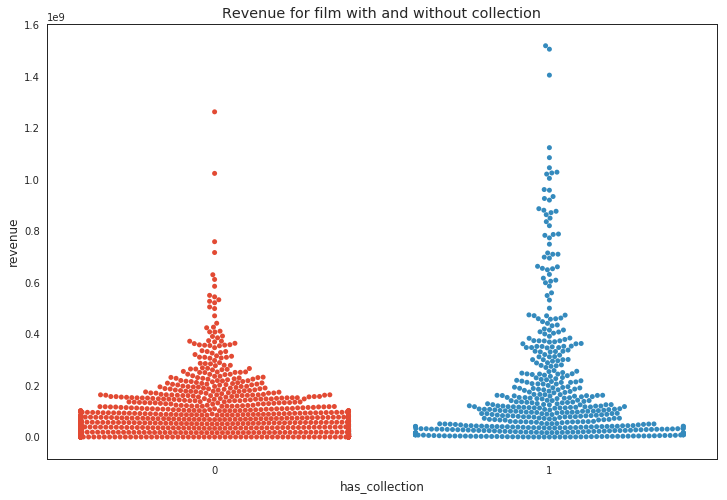

In [16]:
sns.swarmplot(x='has_collection', y='revenue', data=train_df);
plt.title('Revenue for film with and without collection');

In [17]:
# there are lot's of movies with doesn't have collection but earn large revenues

In [18]:
## genres

In [19]:
for i,j in enumerate(train_df.genres[:10]):
    print(f"{i} {j}")

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 16, 'name': 'Animation'}, {'id': 12, 'name': 'Adventure'}, {'id': 10751, 'name': 'Family'}]
5 [{'id': 27, 'name': 'Horror'}, {'id': 53, 'name': 'Thriller'}]
6 [{'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}]
7 [{'id': 18, 'name': 'Drama'}]
8 [{'id': 18, 'name': 'Drama'}]
9 [{'id': 35, 'name': 'Comedy'}, {'id': 80, 'name': 'Crime'}]


In [20]:
## finding list of genres
print('Number of genres in films')
train_df['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


3    708
2    661
1    370
4    321
5     96
6     18
0      5
7      3
Name: genres, dtype: int64

In [21]:
list_of_genres = list(train_df['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

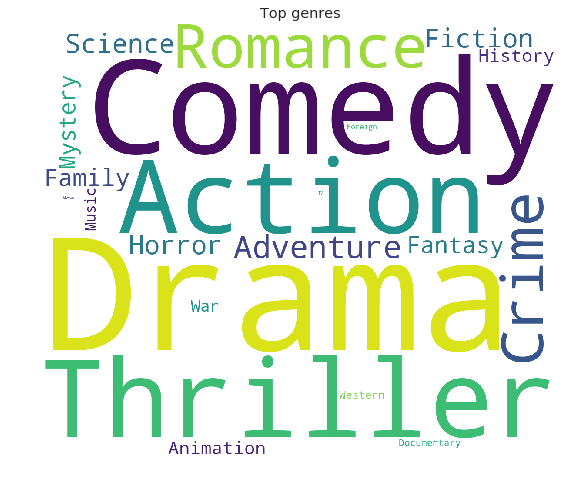

In [22]:
## finding top genres
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)

plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

So, Drama, Thriller and comedy are the top 3 genres

In [23]:
Counter([i for j in list_of_genres for i in j]).most_common()[:4]

[('Drama', 1092), ('Comedy', 726), ('Thriller', 636), ('Action', 610)]

In [24]:
## creating seperate column for top 15 genre

train_df['num_genres'] = train_df['genres'].apply(lambda x: len(x) if x != {} else 0)
train_df['all_genres'] = train_df['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train_df['genre_' + g] = train_df['all_genres'].apply(lambda x: 1 if g in x else 0)
    
test_df['num_genres'] = test_df['genres'].apply(lambda x: len(x) if x != {} else 0)
test_df['all_genres'] = test_df['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test_df['genre_' + g] = test_df['all_genres'].apply(lambda x: 1 if g in x else 0)
    
train_df = train_df.drop(['genres'], axis=1)
test_df = test_df.drop(['genres'], axis=1)

In [25]:
## production_companies

In [26]:
for i,j in enumerate(train_df.production_companies[:5]):
    print(i,j)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [27]:
print('Number of production companies in films')
train_df['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()[:5]

Number of production companies in films


2    534
1    510
3    437
4    253
5    150
Name: production_companies, dtype: int64

In [28]:
# lets look movies with more than 10 production companies
train_df[train_df['production_companies'].apply(lambda x: len(x) if x != {} else 0) > 10].head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Science Fiction,genre_Horror,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_War
363,364,15400000,NaN,tt2053425,fr,De rouille et d'os,"Put in charge of his young son, Ali leaves Bel...",8.398438,/cHCwW8xPl8yPKQwpNzKVinwvirT.jpg,"[{'name': 'France 2 Cinéma', 'id': 83}, {'name...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",5/17/12,123.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Rust and Bone,"[{'id': 494, 'name': 'father son relationship'...","[{'cast_id': 2, 'character': 'St√©phanie', 'cr...","[{'credit_id': '52fe49dd9251416c750d5e05', 'de...",25762027,0,0,2,Drama Romance,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
449,450,80000000,http://asoundofthunder.warnerbros.com/,tt0318081,en,A Sound of Thunder,When a hunter sent back to the prehistoric era...,4.980469,/gsqOX1ReJ5lcmTuDdkhOXLug8Ug.jpg,"[{'name': 'Epsilon Motion Pictures', 'id': 117...","[{'iso_3166_1': 'CZ', 'name': 'Czech Republic'...",5/15/05,110.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Some Rules Should Never Be Broken.,A Sound of Thunder,"[{'id': 3737, 'name': 'dying and death'}, {'id...","[{'cast_id': 34, 'character': 'Alicia Wallenbe...","[{'credit_id': '52fe431e9251416c7500438b', 'de...",5989640,0,0,4,Action Adventure Science Fiction Thriller,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0
554,555,14500000,NaN,tt0293416,ja,Metropolis,Duke Red has overseen the construction of a ma...,9.296875,/1EK7mGCpRKYmSg25FaojvnS9opm.jpg,"[{'name': 'Bandai Visual Company', 'id': 528},...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",5/26/01,108.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...",Released,Welcome to Metropolis,Metropolis,"[{'id': 931, 'name': 'jealousy'}, {'id': 1761,...","[{'cast_id': 1, 'character': 'Tima (voice)', '...","[{'credit_id': '52fe4510c3a36847f80ba41d', 'de...",95789342,0,0,2,Animation Science Fiction,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
805,806,14000000,NaN,tt1748179,en,Red Lights,"Two investigators of paranormal hoaxes, the ve...",11.539062,/iiNGtxUhO2oDeCci7E6OF7OEASk.jpg,"[{'name': 'First Generation Films', 'id': 4908...","[{'iso_3166_1': 'ES', 'name': 'Spain'}, {'iso_...",3/2/12,119.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,How much do you want to believe?,Red Lights,"[{'id': 9853, 'name': 'paranormal'}, {'id': 14...","[{'cast_id': 3, 'character': 'Margaret Matheso...","[{'credit_id': '5366571fc3a3681212002ddf', 'de...",13551174,0,0,1,Thriller,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
880,881,7700000,NaN,tt1372686,en,Coriolanus,"Caius Martius, aka Coriolanus, is an arrogant ...",6.914062,/yE026snGPK1Cm61y6qmPdX5Hh8h.jpg,"[{'name': 'BBC Films', 'id': 288}, {'name': 'S...","[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...",2/14/11,123.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Nature teaches beasts to know their friends.,Coriolanus,"[{'id': 1399, 'name': 'senate'}, {'id': 1402, ...","[{'cast_id': 3, 'character': 'Tullus Aufidius'...","[{'credit_id': '52fe49e9c3a36847f81ad035', 'de...",1072602,0,0,2,Drama Thriller,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
## finding list of companies

list_of_companies = list(train_df['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_of_companies[:5]

[['Paramount Pictures', 'United Artists', 'Metro-Goldwyn-Mayer (MGM)'],
 ['Walt Disney Pictures'],
 ['Bold Films', 'Blumhouse Productions', 'Right of Way Films'],
 [],
 []]

In [30]:
## taking top 30 diffrent companies
Counter([i for j in list_of_companies for i in j]).most_common(30)[:5]

[('Warner Bros.', 173),
 ('Universal Pictures', 154),
 ('Paramount Pictures', 133),
 ('Twentieth Century Fox Film Corporation', 122),
 ('Columbia Pictures', 83)]

In [31]:
## binary col for top 20 production companies

train_df['num_companies'] = train_df['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train_df['all_production_companies'] = train_df['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train_df['production_company_' + g] = train_df['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test_df['num_companies'] = test_df['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test_df['all_production_companies'] = test_df['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test_df['production_company_' + g] = test_df['all_production_companies'].apply(lambda x: 1 if g in x else 0)

    
train_df = train_df.drop(['production_companies', 'all_production_companies'], axis=1)
test_df = test_df.drop(['production_companies', 'all_production_companies'], axis=1)

In [32]:
## production_countries

In [33]:
for i, e in enumerate(train_df['production_countries'][:5]):
    print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 {}


In [34]:
print('Number of production countries in films')
train_df['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts().head()

Number of production countries in films


1    1604
2     403
3      93
4      47
0      19
Name: production_countries, dtype: int64

In [35]:
list_of_countries = list(train_df['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

Counter([i for j in list_of_countries for i in j]).most_common(25)[:5]

[('United States of America', 1786),
 ('United Kingdom', 267),
 ('France', 148),
 ('Germany', 131),
 ('Canada', 95)]

In [36]:
train_df['num_countries'] = train_df['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train_df['all_countries'] = train_df['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train_df['production_country_' + g] = train_df['all_countries'].apply(lambda x: 1 if g in x else 0)
    
test_df['num_countries'] = test_df['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test_df['all_countries'] = test_df['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test_df['production_country_' + g] = test_df['all_countries'].apply(lambda x: 1 if g in x else 0)

    
train_df = train_df.drop(['production_countries', 'all_countries'], axis=1)
test_df = test_df.drop(['production_countries', 'all_countries'], axis=1)

In [37]:
## spoken_languages

for i, e in enumerate(train_df['spoken_languages'][:5]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'en', 'name': 'English'}]


In [38]:
print('Number of spoken languages in films')
train_df['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of spoken languages in films


1    1488
2     425
3     166
4      62
5      22
0       7
7       5
6       5
9       1
8       1
Name: spoken_languages, dtype: int64

In [39]:
list_of_languages = list(train_df['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(30)[:5]

[('English', 1984),
 ('Français', 206),
 ('Español', 189),
 ('Deutsch', 122),
 ('Pусский', 112)]

In [40]:
train_df['num_languages'] = train_df['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train_df['all_languages'] = train_df['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train_df['language_' + g] = train_df['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test_df['num_languages'] = test_df['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test_df['all_languages'] = test_df['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in x])) if x != {} else '')
for g in top_languages:
    test_df['language_' + g] = test_df['all_languages'].apply(lambda x: 1 if g in x else 0)

    
train_df = train_df.drop(['spoken_languages', 'all_languages'], axis=1)
test_df = test_df.drop(['spoken_languages', 'all_languages'], axis=1)

In [41]:
## keywords

In [42]:
for i, e in enumerate(train_df['Keywords'][:5]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [43]:
print('Number of Keywords in films')
train_df['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5     208
6     170
4     165
3     154
7     138
0     135
2     134
8     122
1     117
11    115
Name: Keywords, dtype: int64

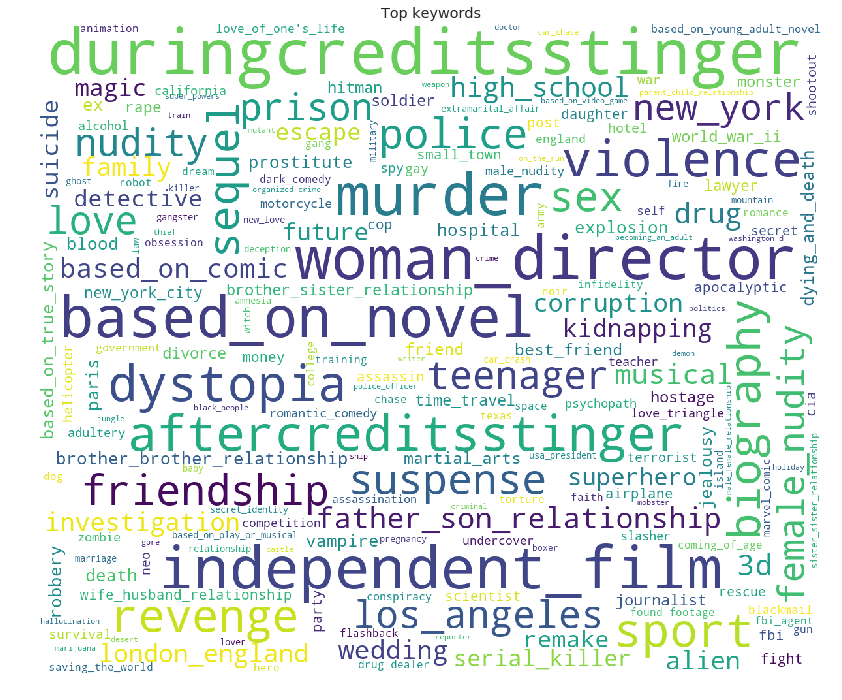

In [44]:
list_of_keywords = list(train_df['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)

plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

In [45]:
train_df['num_Keywords'] = train_df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train_df['all_Keywords'] = train_df['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train_df['keyword_' + g] = train_df['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test_df['num_Keywords'] = test_df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test_df['all_Keywords'] = test_df['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test_df['keyword_' + g] = test_df['all_Keywords'].apply(lambda x: 1 if g in x else 0)

    
train_df = train_df.drop(['Keywords', 'all_Keywords'], axis=1)
test_df = test_df.drop(['Keywords', 'all_Keywords'], axis=1)

In [46]:
## cast

In [47]:
for i, e in enumerate(train_df['cast'][:1]):
    print(i, e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [48]:
print('Number of casted persons in films')
train_df['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


15    163
16    127
18     93
17     91
10     91
13     89
14     88
11     87
12     80
19     78
Name: cast, dtype: int64

In [49]:
## taking most common names...top 15
list_of_cast_names = list(train_df['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)[:5]

[('Samuel L. Jackson', 25),
 ('Robert De Niro', 24),
 ('J.K. Simmons', 23),
 ('Morgan Freeman', 23),
 ('Bruce Willis', 23)]

In [50]:
train_df['num_cast'] = train_df['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train_df['cast_name_' + g] = train_df['cast'].apply(lambda x: 1 if g in x else 0)
    
test_df['num_cast'] = test_df['cast'].apply(lambda x: len(x) if x != {} else 0)
for g in top_cast_names:
    test_df['cast_name_' + g] = test_df['cast'].apply(lambda x: 1 if g in x else 0)
    
train_df = train_df.drop(['cast'], axis=1)
test_df = test_df.drop(['cast'], axis=1)

In [51]:
## release date

In [52]:
test_df.loc[test_df['release_date'].isnull() == True, 'release_date'] = '01/01/98'

In [53]:
def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

In [54]:
train_df['release_date'] = train_df['release_date'].apply(lambda x: fix_date(x))
test_df['release_date'] = test_df['release_date'].apply(lambda x: fix_date(x))

train_df['release_date'] = pd.to_datetime(train_df['release_date'])
test_df['release_date'] = pd.to_datetime(test_df['release_date'])

In [55]:
# creating features based on dates
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

train_df = process_date(train_df)
test_df = process_date(test_df)

train_df.drop('release_date',axis=1, inplace=  True)
test_df.drop('release_date',axis=1, inplace=  True)

In [56]:
d1 = train_df['release_date_year'].value_counts().sort_index()
d2 = test_df['release_date_year'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Number of films per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [57]:
d1 = train_df['release_date_year'].value_counts().sort_index()
d2 = train_df.groupby(['release_date_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))


In [58]:
# The number of films and total revenue are growing, which is to be expected. But there were some years in the past with a high number of successful films, which brought high revenue.

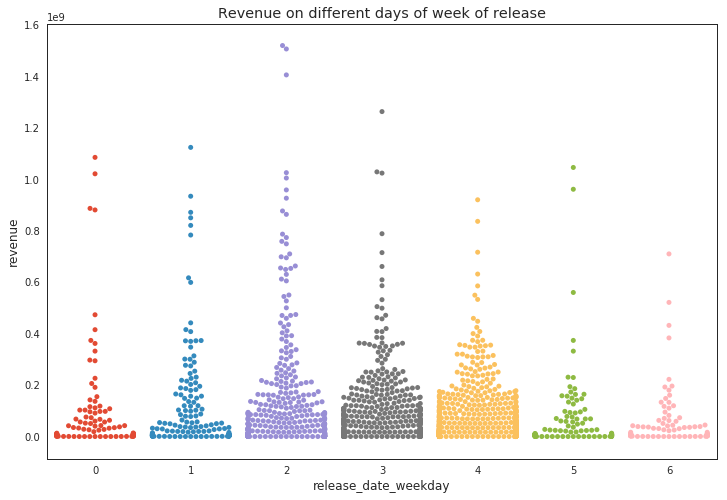

In [59]:
sns.swarmplot(x='release_date_weekday', y='revenue', data=train_df);
plt.title('Revenue on different days of week of release');

In [60]:
## surprisingly films releases on Wednesdays and on Thursdays tend to have a higher revenue
## also, there is large %age of movies released on Friday

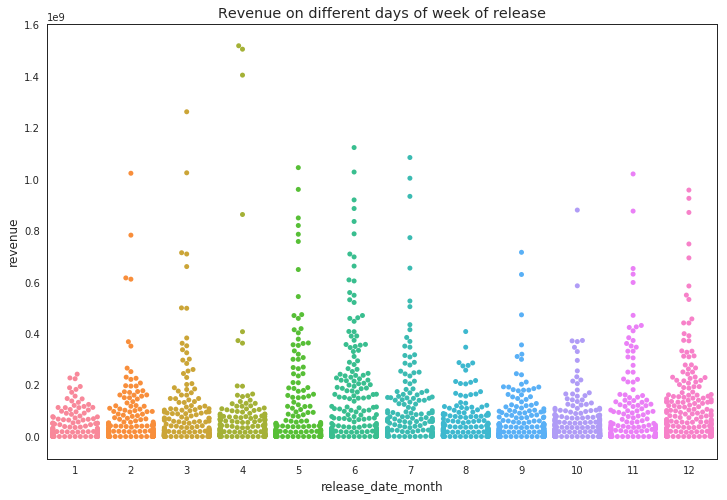

In [61]:
sns.swarmplot(x='release_date_month', y='revenue', data=train_df);
plt.title('Revenue on different days of week of release');

In [62]:
## jan and aug are not that great for movies as compared to other months

In [63]:
## crew

train_df.drop('crew', axis = 1, inplace= True)
test_df.drop('crew', axis =1, inplace = True)

In [64]:
## released

In [65]:
train_df.status.value_counts()

Released    2181
Rumored        1
Name: status, dtype: int64

In [66]:
## let's check those rumored movies

train_df.loc[train_df.status == "Rumored"]

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,runtime,status,tagline,title,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Science Fiction,genre_Horror,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_War,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_New Line Cinema,...,keyword_suspense,keyword_friendship,keyword_police,keyword_sex,keyword_love,keyword_teenager,keyword_los angeles,keyword_nudity,keyword_prison,keyword_female nudity,keyword_new york,keyword_father son relationship,keyword_3d,keyword_drug,keyword_musical,keyword_high school,keyword_based on comic,keyword_wedding,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_J.K. Simmons,cast_name_Morgan Freeman,cast_name_Bruce Willis,cast_name_Bruce McGill,cast_name_Nicolas Cage,cast_name_Jason Statham,cast_name_George Clooney,cast_name_Forest Whitaker,cast_name_Ed Harris,cast_name_Sigourney Weaver,cast_name_Owen Wilson,cast_name_Liam Neeson,cast_name_Sylvester Stallone,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter
1618,1619,891000,NaN,tt0145394,en,A Place Called Chiapas,"On January 1, 1994, the Zapatista National Lib...",0.179199,/4j9U7QMT5D5HhUoIsoAI1niVqz8.jpg,89.0,Rumored,Inside the world's first postmodern revolution,A Place Called Chiapas,229000,0,0,1,Documentary,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1998,4,2,8,20,1


In [67]:
train_df.drop(['imdb_id','status'], axis = 1, inplace=True)
test_df.drop(['imdb_id','status'], axis = 1, inplace=True)

In [68]:
## revenue

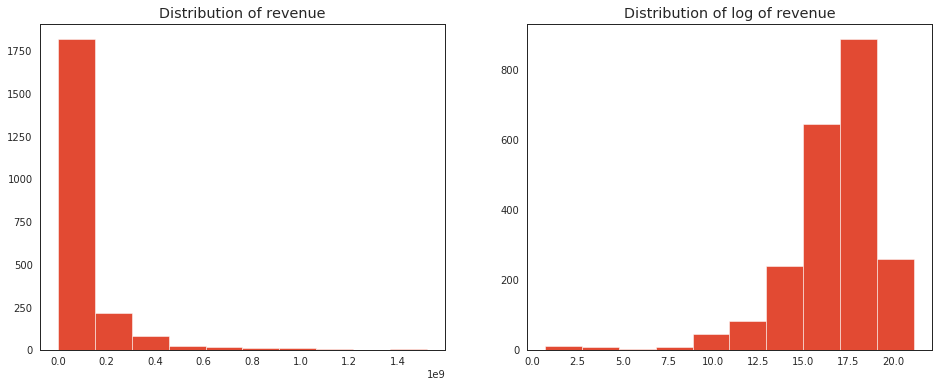

In [69]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train_df['revenue']);
plt.title('Distribution of revenue');

plt.subplot(1, 2, 2)
plt.hist(np.log1p(train_df['revenue']));
plt.title('Distribution of log of revenue');

In [70]:
train_df['revenue'] = np.log1p(train_df['revenue'])

In [71]:
## homepage 

In [72]:
train_df['has_homepage'] = 0
train_df.loc[train_df['homepage'].isnull() == False, 'has_homepage'] = 1
test_df['has_homepage'] = 0
test_df.loc[test_df['homepage'].isnull() == False, 'has_homepage'] = 1

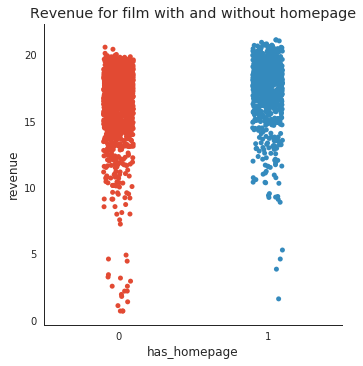

In [73]:
sns.catplot(x='has_homepage', y='revenue', data=train_df);
plt.title('Revenue for film with and without homepage');

In [74]:
# films with homepage likely to generate more revenue
train_df.has_homepage.value_counts()

0    1408
1     774
Name: has_homepage, dtype: int64

In [75]:
train_df.drop('homepage', axis=1, inplace=True)
test_df.drop('homepage', axis=1, inplace=True)

In [76]:
## poster_path

In [77]:
train_df['has_posterpath'] = 0
train_df.loc[train_df['poster_path'].isnull() == False, 'has_posterpath'] = 1
test_df['has_posterpath'] = 0
test_df.loc[test_df['poster_path'].isnull() == False, 'has_posterpath'] = 1

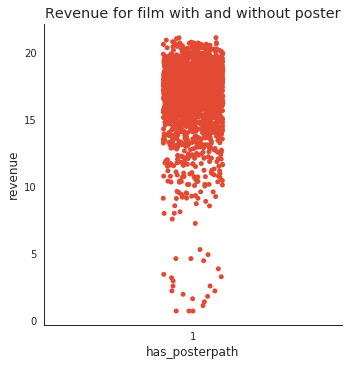

In [78]:
sns.catplot(x='has_posterpath', y='revenue', data=train_df);
plt.title('Revenue for film with and without poster');

In [79]:
train_df.has_posterpath.value_counts()
## every one has poster path so we can drop col

1    2182
Name: has_posterpath, dtype: int64

In [80]:
train_df.drop(['poster_path','has_posterpath'], axis=1, inplace= True)
test_df.drop(['poster_path','has_posterpath'], axis=1, inplace= True)

In [81]:
## original_language

Text(0.5,1,'Count of Language')

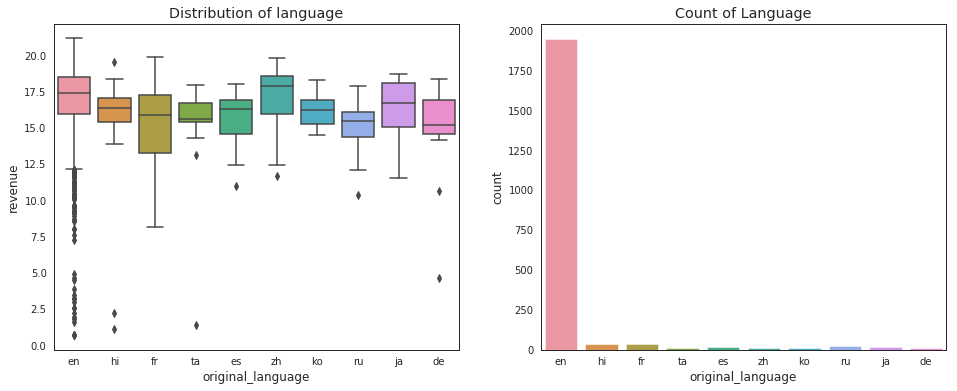

In [82]:
# analysing top 10 languages
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue',data=train_df.loc[train_df['original_language'].isin(train_df['original_language'].value_counts().head(10).index)])
plt.title('Distribution of language');

plt.subplot(1, 2, 2)
sns.countplot(data=train_df.loc[train_df['original_language'].isin(train_df['original_language'].value_counts().head(10).index)], x='original_language')
plt.title('Count of Language')

In [83]:
## majority of the movie are in english with higher revenues but there are other languages too with higher revenues 

In [84]:
train_df.original_language.value_counts()

en    1943
hi      39
fr      39
ru      25
ja      18
es      17
zh      14
ta      13
de      11
ko      11
it      10
cn       8
pt       4
ro       3
nl       3
ml       2
te       2
sv       2
pl       2
fi       2
da       2
id       1
mr       1
no       1
nb       1
sr       1
fa       1
tr       1
hu       1
ur       1
he       1
el       1
vi       1
Name: original_language, dtype: int64

In [85]:
## original_title

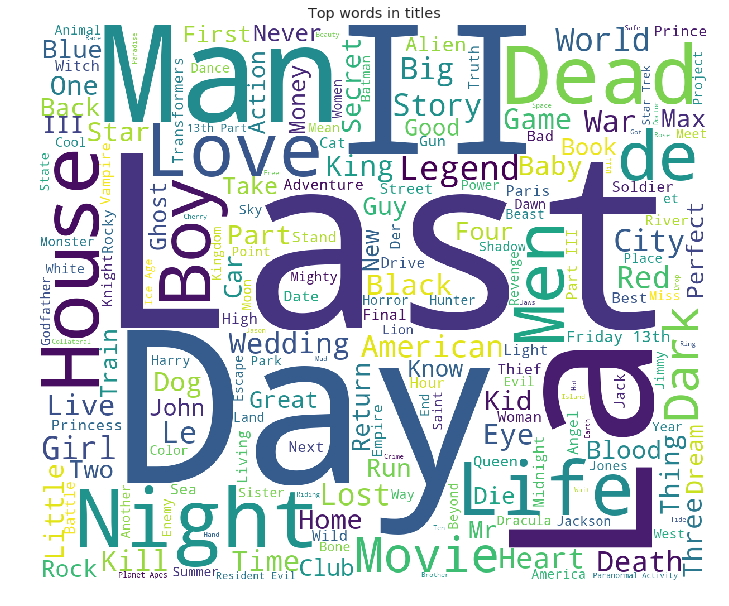

In [86]:
plt.figure(figsize = (12, 12))
text = ' '.join(train_df['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

In [87]:
# counting the title of movie having word "Man"
train_df['original_title'].apply(lambda x: 1 if "Man" in x else 0).value_counts()
# checking th title of movie having word "Man"
# train_df['original_title'].apply(lambda x: print(x) if "Man" in x else 0)

0    2159
1      23
Name: original_title, dtype: int64

In [88]:
## overview

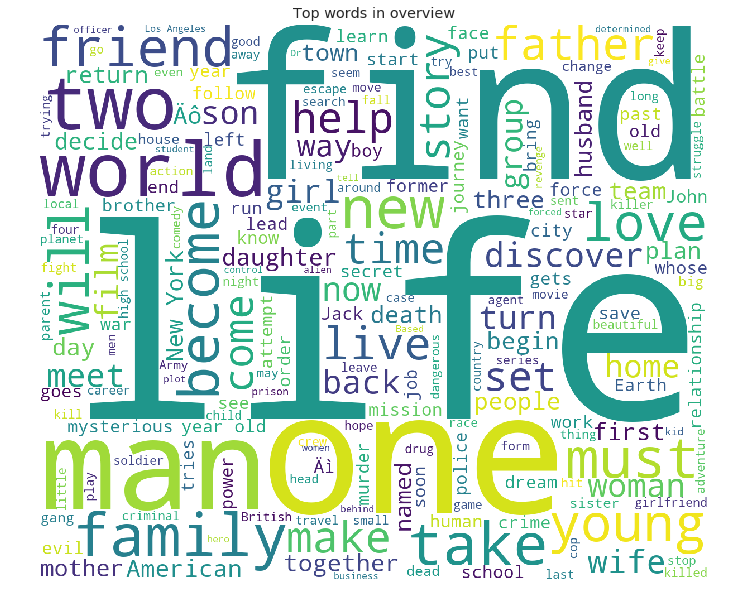

In [89]:
plt.figure(figsize = (12, 12))
text = ' '.join(train_df['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

In [90]:
## popularity

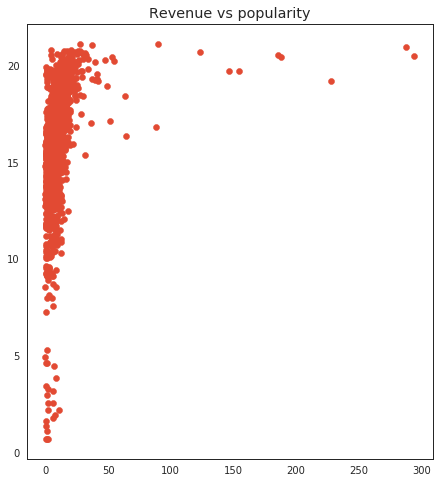

In [91]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(x= train_df['popularity'],y= train_df['revenue'])
plt.title('Revenue vs popularity');

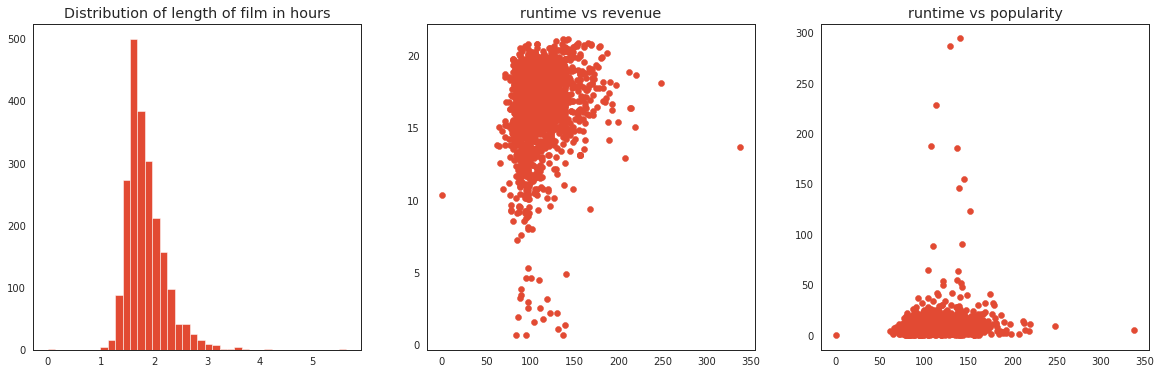

In [92]:
## runtime

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train_df['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');

plt.subplot(1, 3, 2)
plt.scatter(train_df['runtime'].fillna(0), train_df['revenue'])
plt.title('runtime vs revenue');

plt.subplot(1, 3, 3)
plt.scatter(train_df['runtime'].fillna(0), train_df['popularity'])
plt.title('runtime vs popularity');

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a

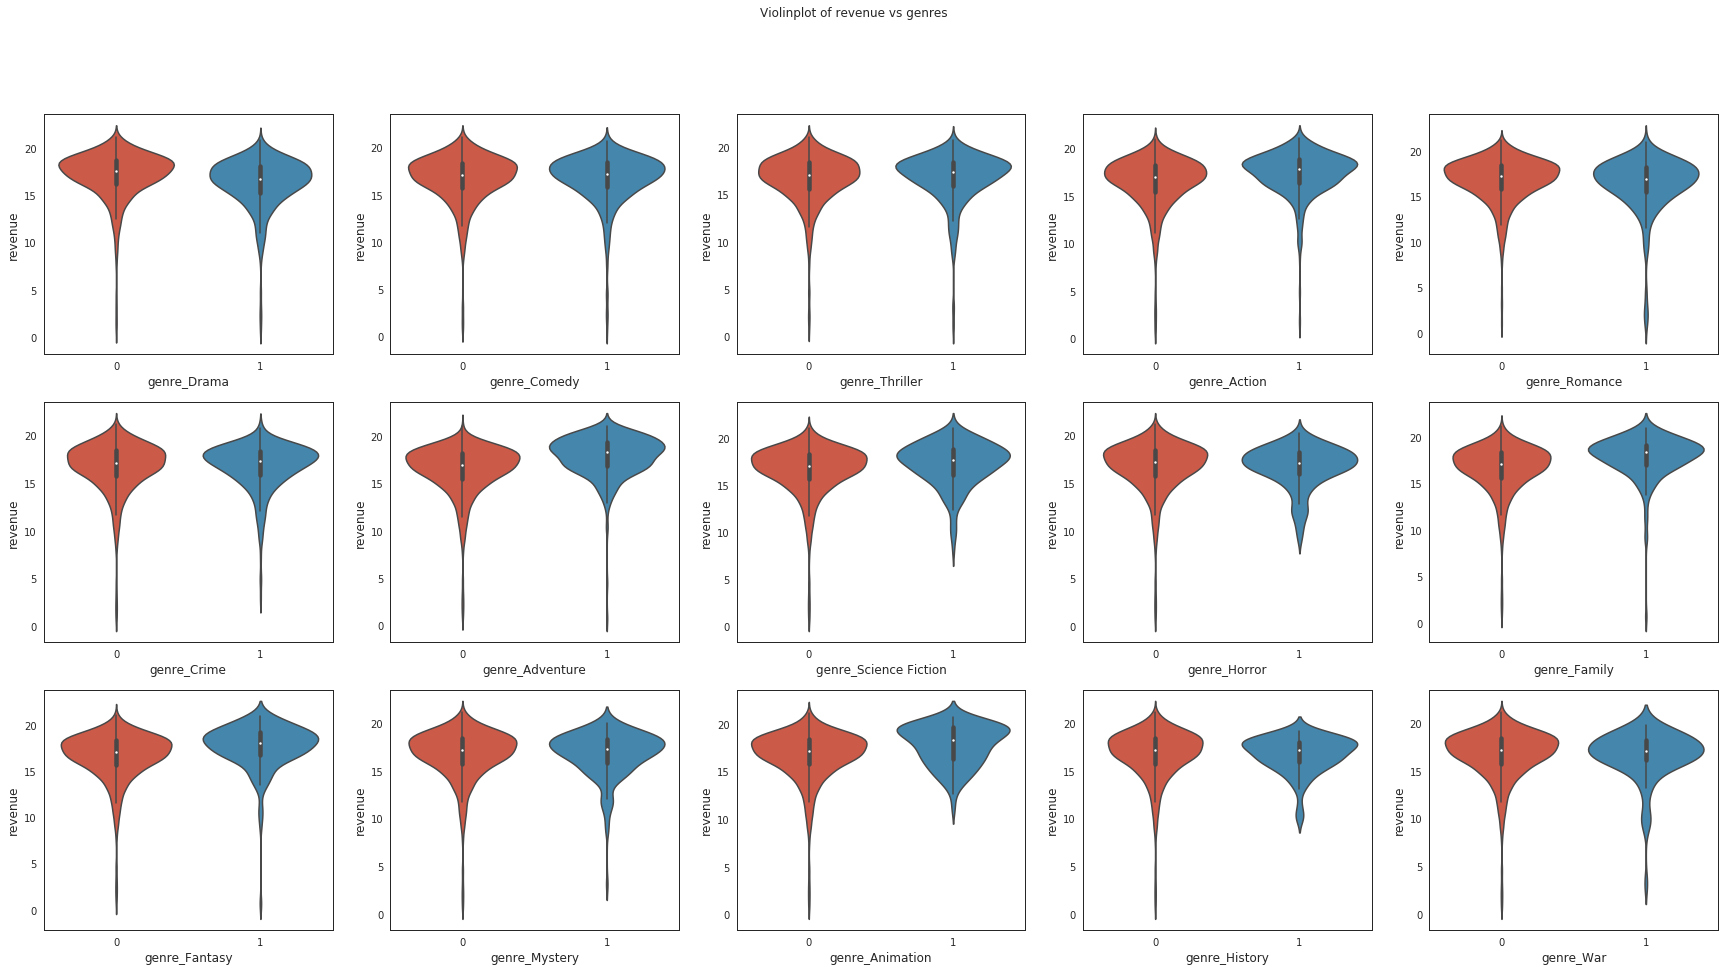

In [93]:
## genres
f, axes = plt.subplots(3, 5, figsize=(30, 15))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in train_df.columns if 'genre_' in col]):
    sns.violinplot(x=e, y='revenue', data=train_df, ax=axes[i // 5][i % 5]);

In [94]:
## basic modelling

In [95]:
train_df.drop(['collection_name','all_genres'], axis=1 ,inplace= True)
test_df.drop(['collection_name','all_genres'], axis=1 ,inplace= True)

In [96]:
for col in train_df.columns:
    if train_df[col].nunique() == 1:
        print(col)
        train_df = train_df.drop([col], axis=1)
        test_df = test_df.drop([col], axis=1)

language_English
language_Français
language_Español
language_Deutsch
language_Pусский
language_Italiano
language_日本語
language_普通话
language_हिन्दी
language_
language_Português
language_العربية
language_한국어/조선말
language_Latin
language_தமிழ்
language_广州话 / 廣州話
language_ภาษาไทย
language_Polski
language_Magyar
language_Český
language_ελληνικά
language_עִבְרִית
language_svenska
language_Tiếng Việt
language_Türkçe
language_తెలుగు
language_Dansk
language_Kiswahili
language_اردو
language_Nederlands
cast_name_Samuel L. Jackson
cast_name_Robert De Niro
cast_name_J.K. Simmons
cast_name_Morgan Freeman
cast_name_Bruce Willis
cast_name_Bruce McGill
cast_name_Nicolas Cage
cast_name_Jason Statham
cast_name_George Clooney
cast_name_Forest Whitaker
cast_name_Ed Harris
cast_name_Sigourney Weaver
cast_name_Owen Wilson
cast_name_Liam Neeson
cast_name_Sylvester Stallone


In [97]:
for col in ['original_language']:
    le = LabelEncoder()
    le.fit(list(train_df[col].fillna('')) + list(test_df[col].fillna('')))
    train_df[col] = le.transform(train_df[col].fillna('').astype(str))
    test_df[col] = le.transform(test_df[col].fillna('').astype(str))

In [98]:
train_df.sample(3)

,id,budget,original_language,original_title,overview,popularity,runtime,tagline,title,revenue,has_collection,num_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Science Fiction,genre_Horror,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_War,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_New Line Cinema,production_company_Metro-Goldwyn-Mayer (MGM),production_company_Walt Disney Pictures,production_company_Touchstone Pictures,production_company_Columbia Pictures Corporation,production_company_Relativity Media,production_company_TriStar Pictures,...,num_languages,num_Keywords,keyword_duringcreditsstinger,keyword_woman director,keyword_murder,keyword_independent film,keyword_based on novel,keyword_violence,keyword_dystopia,keyword_aftercreditsstinger,keyword_sport,keyword_revenge,keyword_biography,keyword_sequel,keyword_suspense,keyword_friendship,keyword_police,keyword_sex,keyword_love,keyword_teenager,keyword_los angeles,keyword_nudity,keyword_prison,keyword_female nudity,keyword_new york,keyword_father son relationship,keyword_3d,keyword_drug,keyword_musical,keyword_high school,keyword_based on comic,keyword_wedding,num_cast,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,has_homepage
802,803,7000000,9,The Extra Man,THE EXTRA MAN is a sophisticated and moving co...,3.185547,108.0,"They're not gigolos, they're gentlemen.",The Extra Man,13.023824,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,2010,6,8,30,1,3,1
339,340,11000000,9,The Molly Maguires,Life is rough in the coal mines of 1876 Pennsy...,2.273438,124.0,NaN,The Molly Maguires,14.603968,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,...,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,1970,1,1,5,27,1,0
1059,1060,40000000,9,The Living Daylights,James Bond helps a Russian General escape into...,12.187500,130.0,Licensed to thrill.,The Living Daylights,19.068757,1,3,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,...,7,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,49,1987,0,6,27,29,2,1


In [99]:
train_df.to_csv('train_cleaned.csv',index=False)
test_df.to_csv('test_cleaned.csv',index=False)